# Case 2: Pneumonia
### Model 1
**27.02.2021**<br>
Andrey Verbovskiy<br>
Neural Networks for Health Technology Applications<br>
[Metropolia University of Applied Sciences](https://www.metropolia.fi/en)

## 1. Introduction

The objective of this case study is to create at Convolutional Neural Network model to predict whether or not a patient has pneumonia or not, based on x-ray images. For this report, I have created three separate models for this prediction. This first model is the best out of the three.

I used Kaggle to create the models, as the addition of the GPU accelerator made running through several iterations of models much faster than with simple CPU power. One epoch with CPU takes over minutes, with GPU each epoch was complete in only a few seconds.

In this Notebook, I will discuss the various approaches taken and the different methods we trialed. 

In [1]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential

## 2. Dataset

The dataset used is a collection of x-ray images classified as "NORMAL", for a healthy patient, and "PNEUMONIA", for a patient with pneumonia. The training data and testing data were already nicely separated into different directories, therefore the data did not need to be manually separated into training and testing sets.

In [2]:
batch_size = 32
img_height = 180
img_width = 180

In [3]:
train_dir = "./ChestXRay2017/chest_xray/train"
test_dir = "./ChestXRay2017/chest_xray/test"
os.listdir(train_dir)

['.DS_Store', 'NORMAL', 'PNEUMONIA']

## 3. Preprocessing

### Split Training Directory into Training and Validation Datasets

**Training**

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split = 0.2,
  subset = "training",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 5232 files belonging to 2 classes.
Using 4186 files for training.


**Validation**

In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split = 0.2,
  subset = "validation",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 5232 files belonging to 2 classes.
Using 1046 files for validation.


### Create Testing Dataset

In [6]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 624 files belonging to 2 classes.


### Printing the Class Names

In [7]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


### Autotune the Data

I used autotune on this dataset to improve the data processing speed

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

### Visualizing the Data

Here I wanted to see what a sample of the training images look like, and to see the visual difference between a healthy patient and a patient with pneumonia.

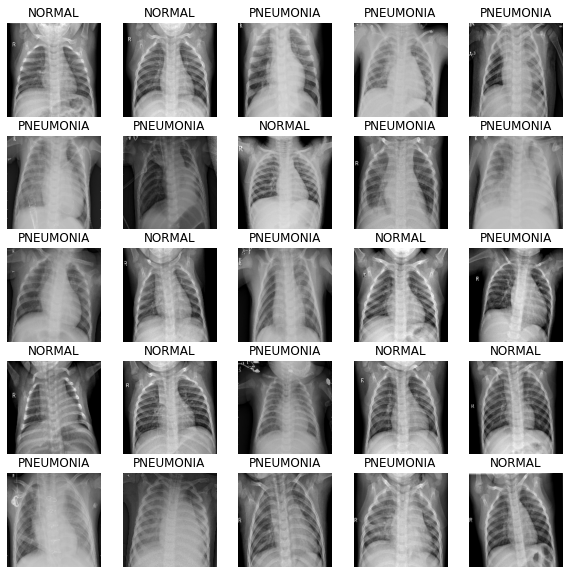

In [9]:
plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## 4. Modeling

For this model, I used a normalization layer, followed by four Conv2D() layers. Each hidden layer utilises Dropout() to reduce overfitting. For each hidden layer, I used the ReLU activation function, and sigmoid activation function for the output layer, as this is a binary classification and sigmoid works well to illustrate that. 

I used binary_crossentropy for the loss function, without testing others, as I learned from the previous case study that this was the only acceptable loss function for binary classification. For the optimizer, I tested both RMSprop and Adam, and came to the conclusion that while Adam gave me a better overall accuracy, specificity and sensitivity in the training and validation datasets in absolute numbers, the model was found to be slightly too overfitted from the resulting training and validation graphs. Therefore, I used RMSProp for the loss function in this model, which resulted in a better middle ground.

For metrics, I used accuracy as before, with the addition of SpecificityAtSensitivity() and SensitivityAtSpecificity. This was done because, despite multiple efforts to use sklearn classification_report to generate accuracy, sensitivity, and specificity data, this was not compatible with the dataset generator I used in this case study. 

### Create Normalization Layer

This could have been added as-is to the model, but I thought it would be better to separate it out to make it clear what this layer signified.

In [10]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))

### Creating the Model

In [11]:
model = Sequential([
    normalization_layer,
    
    layers.Conv2D(16, (3, 3), padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),
    
    layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),
    
    layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    
    layers.Dense(1, activation = 'sigmoid')
])

model.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop(lr = 1e-4), 
              metrics = ['accuracy', tf.keras.metrics.SpecificityAtSensitivity(0.5), 
                         tf.keras.metrics.SensitivityAtSpecificity(0.5)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 45, 45, 32)        0

## 5. Training

The training here was relatively simple, and did not require too much testing in and of itself. For this model, I used 10 epochs to for training, as beyond this point the accuracy values stagnated, as did the sensitivity and specificity. 5 epochs resulted in a slightly underfitted model, with specificity in the validation data in particular suffering somewhat.

In [12]:
%%time
E = 10
h = model.fit(      
      train_ds,
      validation_data = val_ds,
      verbose = 0, 
      epochs = E)

Wall time: 28min 56s


## 6. Evaluation and Results

The results seen here for the training and validation data are not exactly the same as I received from our Kaggle experiments. It is clear that the models are slightly overfitted, which is possibly the reason why the model did not perform as well as the other two in terms of accuracy when presented with the test data.

### Get Keywords

As the use of the extra metrics was new to us, we used the code below to check the keywords for the evaluation plots.

In [13]:
h_dict = h.history
h_dict.keys()

dict_keys(['loss', 'accuracy', 'specificity_at_sensitivity', 'sensitivity_at_specificity', 'val_loss', 'val_accuracy', 'val_specificity_at_sensitivity', 'val_sensitivity_at_specificity'])

### Keyword Declarations

In [14]:
loss = h.history['loss']
acc = h.history['accuracy']
val_loss = h.history['val_loss']
val_acc = h.history['val_accuracy']
senSpec = h.history['sensitivity_at_specificity']
val_senSpec = h.history['val_sensitivity_at_specificity']
specSen = h.history['specificity_at_sensitivity']
val_specSen = h.history['val_specificity_at_sensitivity']

x = np.arange(len(loss)) + 1

### Plot of the Training and Validation Loss

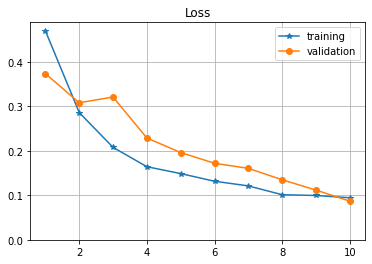

In [15]:
plt.plot(x,loss, '*-', label = 'training')
plt.plot(x, val_loss, 'o-', label = 'validation')
plt.title('Loss')
plt.ylim(0, )
plt.legend()
plt.grid()

### Plot of the Training and Validation Accuracy

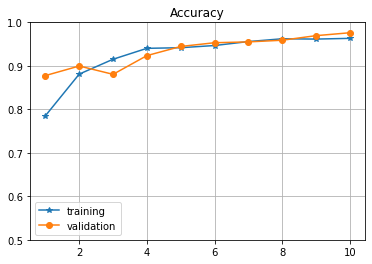

In [16]:
plt.plot(x, acc, '*-', label = 'training')
plt.plot(x, val_acc, 'o-', label = 'validation')
plt.title('Accuracy')
plt.ylim(0.5, 1.0)
plt.legend()
plt.grid()

### Plot of the Training and Validation Sensitivity at Specificity

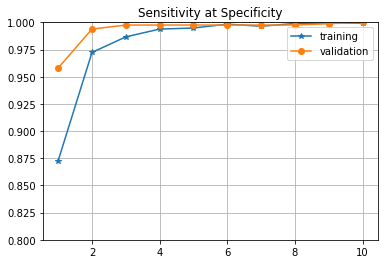

In [17]:
plt.plot(x, senSpec, '*-', label = 'training')
plt.plot(x, val_senSpec, 'o-', label = 'validation')
plt.title('Sensitivity at Specificity')
plt.ylim(0.8, 1)
plt.legend()
plt.grid()

### Plot of the Training and Validation Specificity at Sensitivity

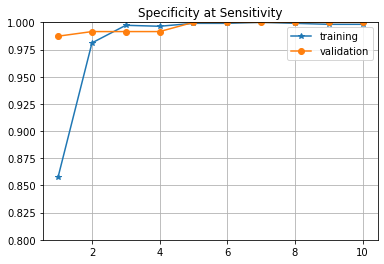

In [18]:
plt.plot(x,specSen, '*-', label = 'training')
plt.plot(x, val_specSen, 'o-', label = 'validation')
plt.title('Specificity at Sensitivity')
plt.ylim(0.8, 1)
plt.legend()
plt.grid()

### Performance Evaluation

As can be seen below, the model performed decently well even with unseen data. The overall accuracy is lower than the model showed with the training and validation sets, but the specificity and sensitivity are both over 90%, therefore the model was not too overfitted for the validation datasets.

In [19]:
results = model.evaluate(test_ds, verbose = 0)
print('The testing accuracy is :', results[1]*100, '%')
print('The testing specificity is :', results[2]*100, '%')
print('The testing sensitivity is :', results[3]*100, '%')

The testing accuracy is : 78.52563858032227 %
The testing specificity is : 97.43589758872986 %
The testing sensitivity is : 99.23076629638672 %


## 7. Conclusions

Overall, this was my best performing model based on the training and validation data. The accuracy, sensitivity and specificity were all very good in the model (over 90% for all three), and the model performed very well with the test data as well, though with a lower accuracy than with the training and validation sets. This is to be expected, as the test data is completely new to the model, though upon reflection, this model is somewhat overfitted, and declaring it the "best" model based on the training data and not the testing data was possibly premature. In comparison to Model 1, Model 2 also performed very well with the testing data, achieving a higher accuracy with the testing data as well as similar specificity and sensitivity values. Our reasoning for why I chose this as my "best" model is purely based on the numbers received from the training data.

As mentioned previously, the model used the metrics SpecificityAtSensitivity and SensitivityAtSpecificity, since manipulation the image datasets into one compatible with sklearn classification_report (and therefore confusion_matrix) turned out to be a much larger task than we had anticipated. Many of the examples we tried ([example 1](https://www.kaggle.com/oluwaseunilori/pneumonia-prediction-recall-0-99-precision-0-75), [example 2](https://www.kaggle.com/adinishad/95-accuracy-chest-x-ray-images-pneumonia)) used functions that had no commentary and were difficult to decipher, or were deprecated entirely. Instead, I opted to use the dataset generator from our class example ([link](https://www.tensorflow.org/tutorials/images/classification)) and use the aforementioned metrics to see the change in sensitivity and specificity.

This model could of course be further improved. Another layer or two to the model could help further with avoiding underfitting, though there is a danger there of leaning toward overfitting. A table or grid of predicted vs actual diagnoses for select images could have been presented, making it simple to see how the model is actually performing. Finally, as previously mentioned, the optimizer 'Adam' gave a better accuracy result, but looked to lean towards overfitting. With some refinement to the layers, perhaps the use of 'Adam' could have given a better accuracy result in unseen data as well, while avoiding overfitting to the training data.